In [1]:

'''
Topic Modeling with Top2Vec: Minimum Viable Example
References:
[1] https://github.com/ddangelov/Top2Vec
[2] https://top2vec.readthedocs.io/_/downloads/en/stable/pdf/
'''
from top2vec import Top2Vec
import time
import numpy as np
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from gensim.utils import tokenize
pd.set_option('mode.chained_assignment', None)


C:\Users\jared\.conda\envs\top2vec_scratch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def replaceKeyword(x, keyword_list):
    '''
    Input:
    - x: input string
    - keyword_list: list of keywords to replace with
    Output:
    - label: string of fixed word. If keywords do not exist in string, return None
    '''
    label=None
    for keyword in keyword_list:
        if label == None:
            try: 
                if keyword in x:
                    label=keyword
            except:
                label=None
    
    if label== None:
        return "other"
    else:
        return label


def simplifyJobs(df):
    '''
    Input:
    - df: dataframe of job postings
    Output:
    - docs: list of strings representing input documents. The job postings are simplified.
    '''
    shortened_dict = {'Machine Learning': 'ML', 'Business Intelligence': 'BI', 'Developer Operations': 'DevOps', 'Artificial Intelligence': 'AI'}
    job_titles=['DataAnalyst','DataEngineer','DataScientist','MachineLearningEngineer', 'BIAnalyst',
           'AIEngineer','SoftwareEngineer','DevOpsEngineer','Architect','BigDataEngineer', 'ResearchScientist']
    df = df.dropna(thresh = 5)
    df['Job Title'] = df['Job Title'].str.replace(' ', '') # shorten job title
    df['Job Title'] = df['Job Title'].replace(shortened_dict, regex = True)
    df['JobTitleClean'] = pd.Series( [replaceKeyword(x, job_titles ) for x in df['Job Title']])
    df['JobTitleClean'] = df['JobTitleClean'].fillna("other") # other for all jobs not in title
    df['Requirment of the company '] = df['Requirment of the company '].fillna('Unknown Company')
    df['Experience level'] = df['Experience level'].fillna('Unknown Experience Level')
    df['posting'] = df['JobTitleClean'] + " " + df['Requirment of the company '] + " " + df['Experience level'] # not including company
    df['posting'] = df['posting'].str.replace(",", " ")
    df['posting'] = df['posting'].str.replace("-", "")
    docs = df['posting'].to_list()
    return docs


In [3]:
df = pd.read_csv('ai-jobs_data_science_job.csv', encoding = 'latin-1')

docs = simplifyJobs(df)
docs

['DataAnalyst Computer Science Data quality Genetics Mathematics SAS Statistics Entrylevel',
 'DataAnalyst Agile Data management Finance Security   Entrylevel',
 'MachineLearningEngineer Agile Architecture AWS Computer Science Computer Vision Deep Learning Unknown Experience Level',
 'DataAnalyst Engineering Industrial Oracle Power BI R R&D Entrylevel',
 'DataEngineer AWS Azure Computer Science Consulting Dataflow Data pipelines Midlevel',
 'DataScientist Computer Science Deep Learning Industrial Machine Learning NLP NumPy Seniorlevel',
 'other Banking Data quality Excel Security   Entrylevel',
 'other Business Intelligence Excel Genetics    Entrylevel',
 'DataEngineer Big Data Computer Science Engineering Machine Learning Mathematics Matlab Entrylevel',
 'DataEngineer Agile APIs AWS Azure Big Data Computer Science Seniorlevel',
 'DataScientist Computer Science Data analysis Deep Learning Keras Machine Learning PhD Entrylevel',
 'DataAnalyst Business Analytics Business Intelligence Dat

In [4]:

# Create jointly embedded topic, document and word vectors
load_model_time = time.time()
topic_model = Top2Vec(
  docs, 
  embedding_model = 'doc2vec', # Embedding model
  min_count = 10,              # Ignore words less frequent than this value
  umap_args = None,            # Dict of custom args for UMAP
  hdbscan_args = None          # Dict of custom argd for HDBSCAN
  )
topic_sizes, topic_nums = topic_model.get_topic_sizes()
print(topic_sizes)
print(topic_nums)
end_load_model = time.time()
print("Total time to load model: ", end_load_model - load_model_time)

2024-05-20 19:46:38,387 - top2vec - INFO - Pre-processing documents for training
2024-05-20 19:46:38,554 - top2vec - INFO - Creating joint document/word embedding
2024-05-20 19:46:42,366 - top2vec - INFO - Creating lower dimension embedding of documents
2024-05-20 19:46:54,813 - top2vec - INFO - Finding dense areas of documents
2024-05-20 19:46:54,929 - top2vec - INFO - Finding topics


[1363  993  319  268  254]
[0 1 2 3 4]
Total time to load model:  16.548614978790283


In [6]:

load_model_time = time.time()

# for title in job_titles:
#     topic_words, word_scores, topic_scores, topic_nums = topic_model.search_topics(
#         keywords = [DataAnalyst], 
#         num_topics = 5)
#     print(title)
#     print(topic_nums)
#     print('--------')
print("Topics: ", topic_model.get_num_topics())
topic_words, word_scores, topic_scores, topic_nums = topic_model.search_topics(
    keywords = ['DataAnalyst'], 
    num_topics = 2)
print('DataAnalyst')
print(topic_nums)
print('--------')
end_load_model = time.time()
print("Total time to load model: ", end_load_model - load_model_time)

Topics:  5
DataAnalyst
[0 4]
--------
Total time to load model:  0.002014636993408203


In [7]:
job_titles=['DataAnalyst','DataEngineer','DataScientist','MachineLearningEngineer', 'BIAnalyst', 
            'AIEngineer','SoftwareEngineer','DevOpsEngineer','Architect','BigDataEngineer', 'ResearchScientist']
for title in job_titles:
    print(title)
    try:         
        words, word_scores = topic_model.similar_words(keywords=[title], keywords_neg=[], num_words=10)
        print("Top 10 words closest to ", title)
        print(title, dict(zip(words, word_scores)))
        print("------------------------------------")
        topic_words, word_scores, topic_scores, topic_nums = topic_model.search_topics(keywords=[title], num_topics=2)
        print("Topics closest to ", title, ": ", topic_nums)
        # dict_words = dict(zip(topic_words, word_scores))
        # print(title, dict_words)
        index = 0
        for topic in topic_nums:
            print(f"{title} cosine similarity to topic {topic} is {topic_scores[index]}")
            print("------------------------------------")
            print(f"Top 10 words in topic {topic}: ")
            print(dict(zip(topic_words[index][:10], word_scores[index][:10]))) # top 10 words and vals
            index += 1
        # print(topic_words, word_scores, topic_scores, topic_nums)
        print("\n")

    except ValueError as ve:
        print(title, 'Failed: ')
        print(str(ve))
        print("\n")
    

DataAnalyst
Top 10 words closest to  DataAnalyst
DataAnalyst {'data': 0.35755347964671286, 'learning': 0.3548146102952886, 'midlevel': 0.35190213048818064, 'other': 0.33092003788283, 'datascientist': 0.3248225030657921, 'seniorlevel': 0.31260594794111995, 'engineering': 0.3093034099611869, 'banking': 0.3058856645161394, 'cx': 0.30072786993547995, 'computer': 0.29526797777474223}
------------------------------------
Topics closest to  DataAnalyst :  [0 4]
DataAnalyst cosine similarity to topic 0 is 0.3129705543234938
------------------------------------
Top 10 words in topic 0: 
{'intelligence': 0.7667315, 'data': 0.7262087, 'blockchain': 0.7146677, 'dataengineer': 0.6893835, 'other': 0.6604179, 'business': 0.65871704, 'experience': 0.6544318, 'midlevel': 0.64479744, 'sql': 0.6341058, 'gcp': 0.63146937}
DataAnalyst cosine similarity to topic 4 is 0.10257445606968417
------------------------------------
Top 10 words in topic 4: 
{'pipelines': 0.16266298, 'distributed': 0.16085579, 'unkno

In [8]:
topic_words, word_scores, topic_nums = topic_model.get_topics(5)
for topic in topic_nums:

            print("------------------------------------")
            print(f"Top 10 words in topic {topic}: ")
            print(dict(zip(topic_words[topic][:10], word_scores[topic][:10]))) # top 10 words and vals

------------------------------------
Top 10 words in topic 0: 
{'intelligence': 0.7667315, 'data': 0.7262087, 'blockchain': 0.7146677, 'dataengineer': 0.6893835, 'other': 0.6604179, 'business': 0.65871704, 'experience': 0.6544318, 'midlevel': 0.64479744, 'sql': 0.6341058, 'gcp': 0.63146937}
------------------------------------
Top 10 words in topic 1: 
{'driving': 0.749845, 'discovery': 0.72212636, 'chatgpt': 0.70714176, 'deep': 0.69636464, 'drug': 0.68180907, 'modeling': 0.6760322, 'model': 0.66038775, 'executivelevel': 0.6436503, 'open': 0.6265212, 'ml': 0.6170471}
------------------------------------
Top 10 words in topic 2: 
{'cassandra': 0.19352224, 'google': 0.17679694, 'bigquery': 0.14222415, 'business': 0.13983648, 'cloud': 0.13959399, 'datascientist': 0.1395527, 'dataflow': 0.13338399, 'bianalyst': 0.12383179, 'gitlab': 0.1200502, 'privacy': 0.11957903}
------------------------------------
Top 10 words in topic 3: 
{'intelligence': 0.32524526, 'consulting': 0.29903835, 'kpis':

In [9]:
# Evaluate coherence score
topic_words, word_scores, topic_nums = topic_model.get_topics()

# Reference: https://github.com/ddangelov/Top2Vec/issues/30
tokenized = [list(tokenize(s)) for s in docs]
id2word = corpora.Dictionary(tokenized)
corpus = [id2word.doc2bow(text) for text in tokenized]
        
coherence_model_top2vec = CoherenceModel(topics=[s.tolist() for s in topic_words], texts=tokenized,
                     corpus=corpus, dictionary=id2word, coherence='c_v')

coherence_top2vec = coherence_model_top2vec.get_coherence()

print("Top2Vec Coherence C_V is: {0}".format(coherence_top2vec))

Top2Vec Coherence C_V is: 0.4296910257454333


Total time to load model:  1.4794178009033203


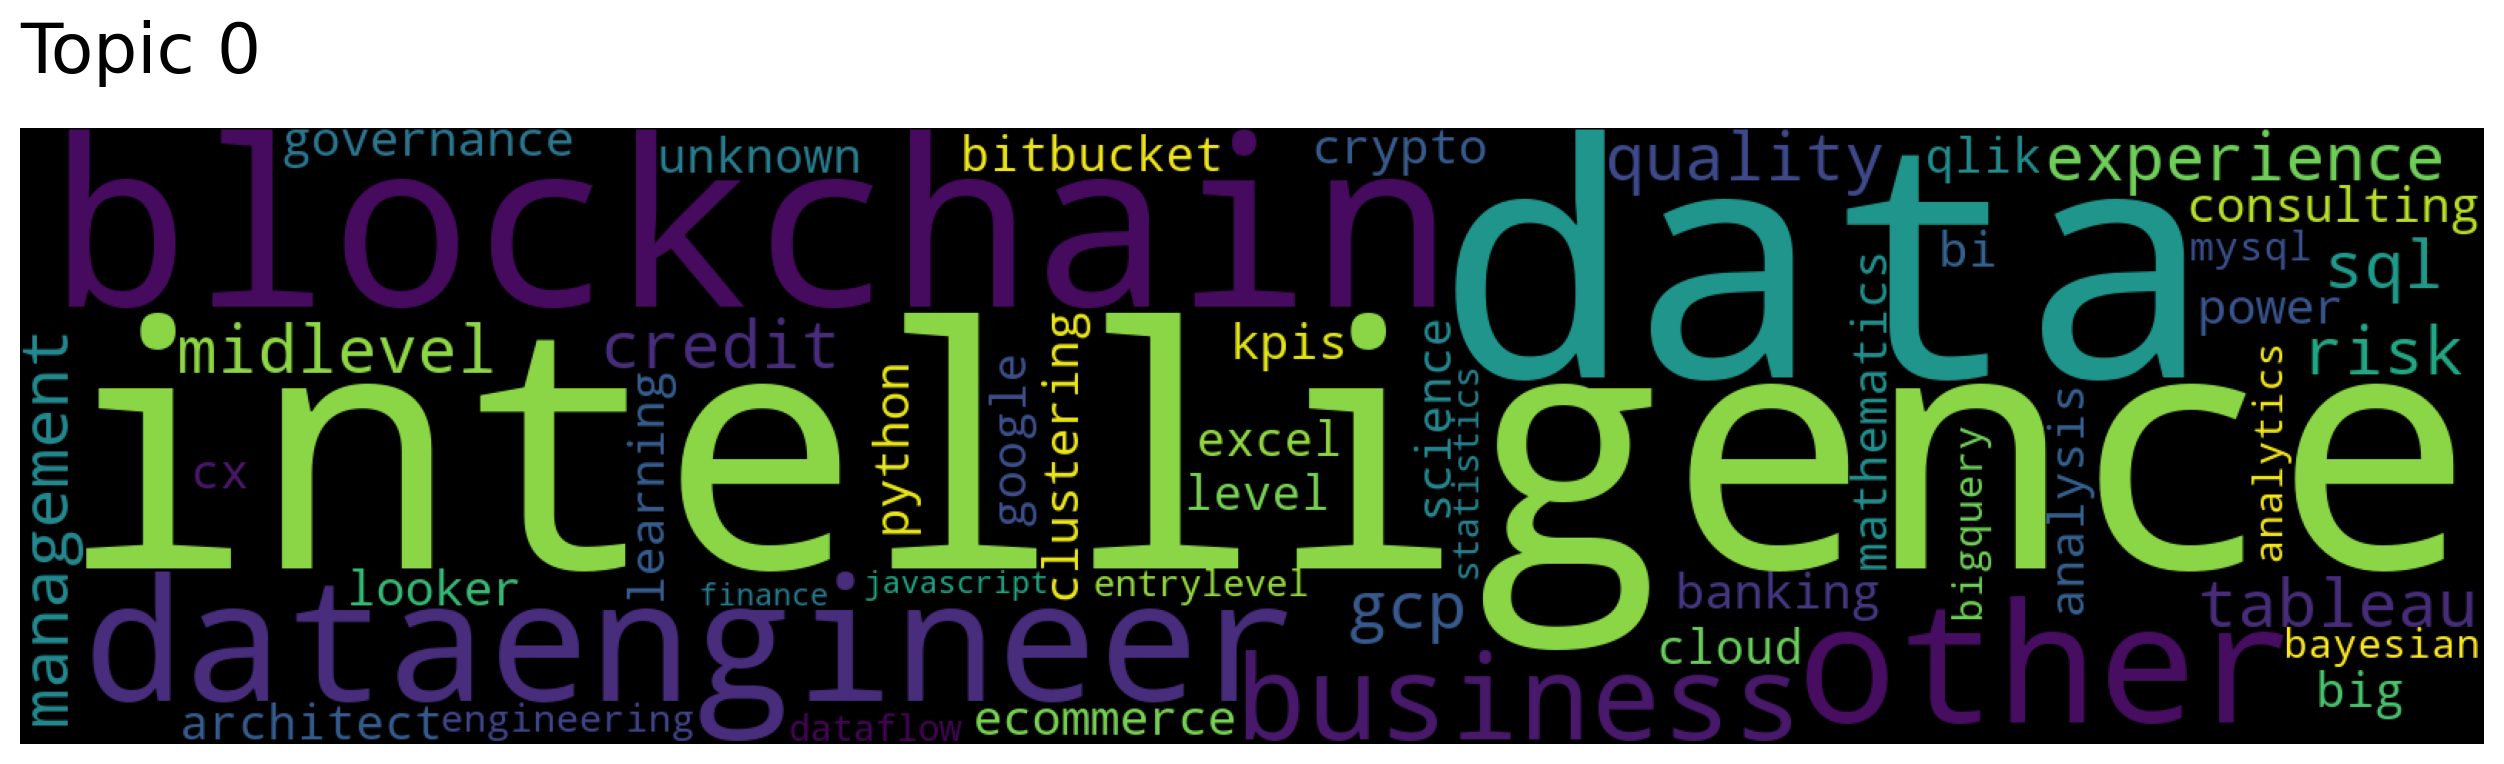

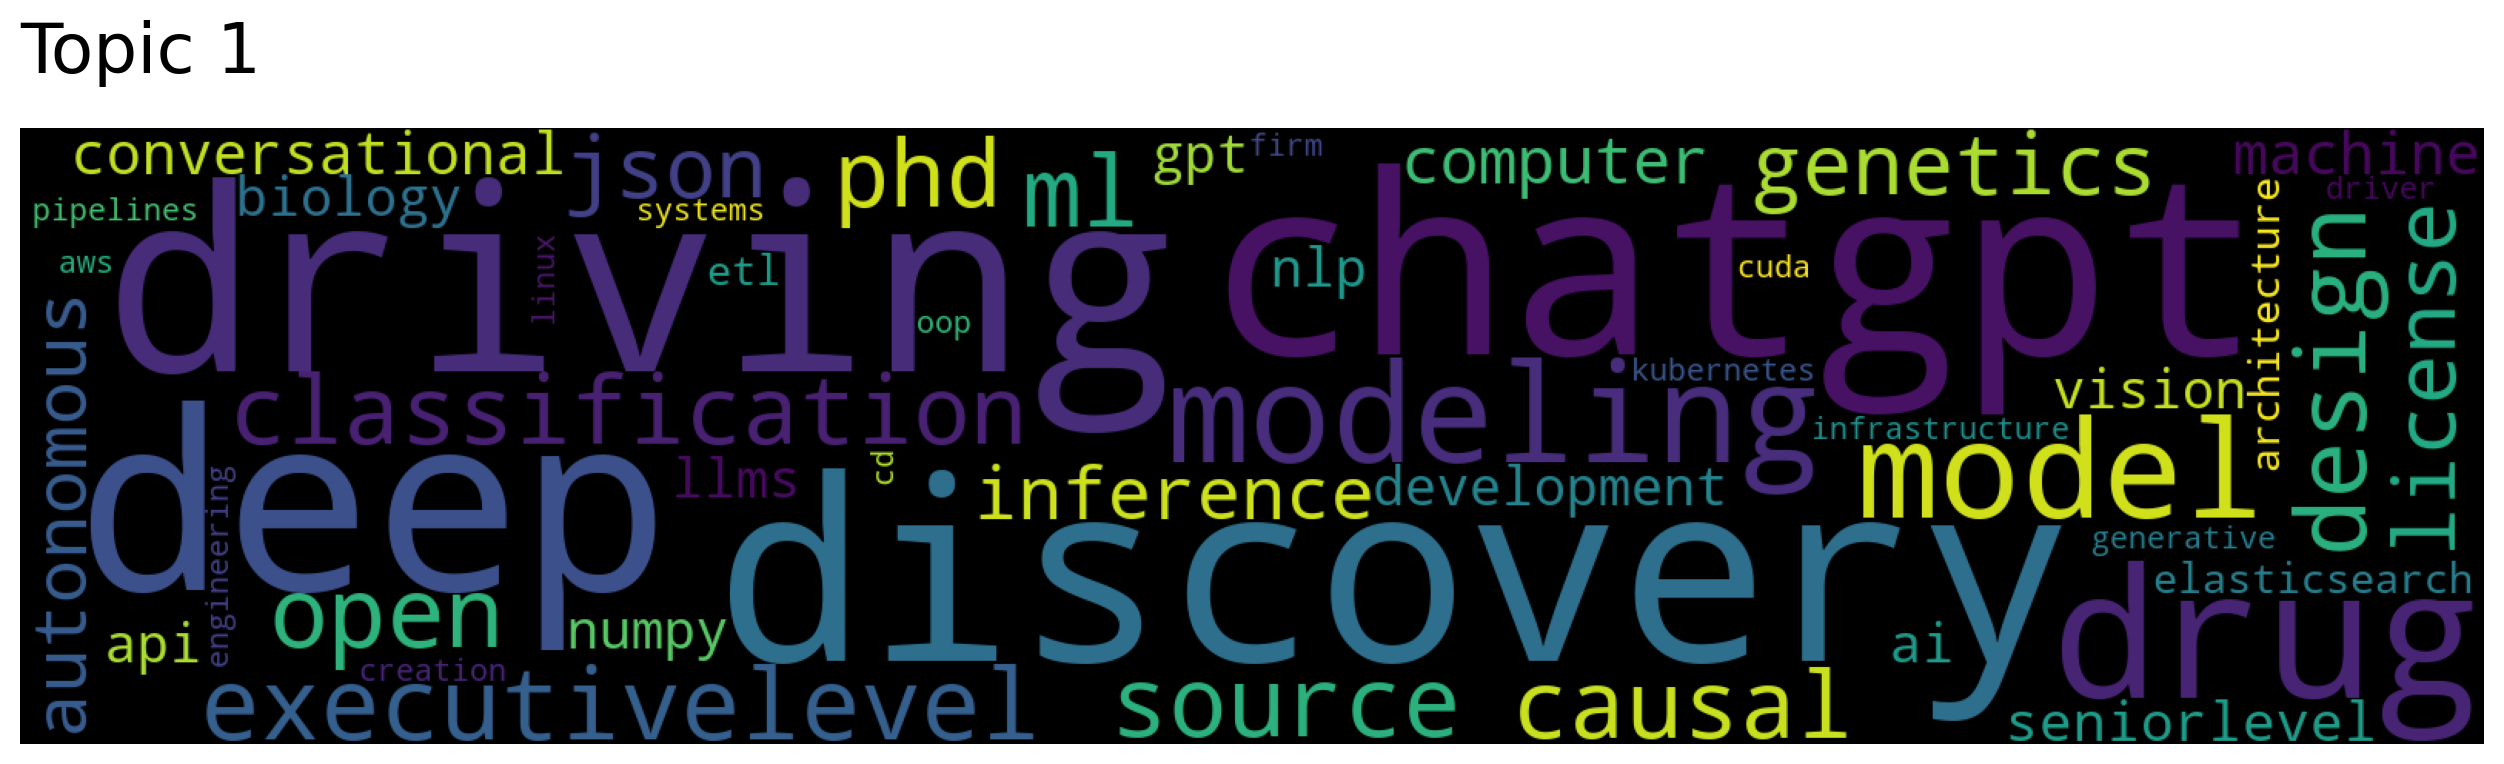

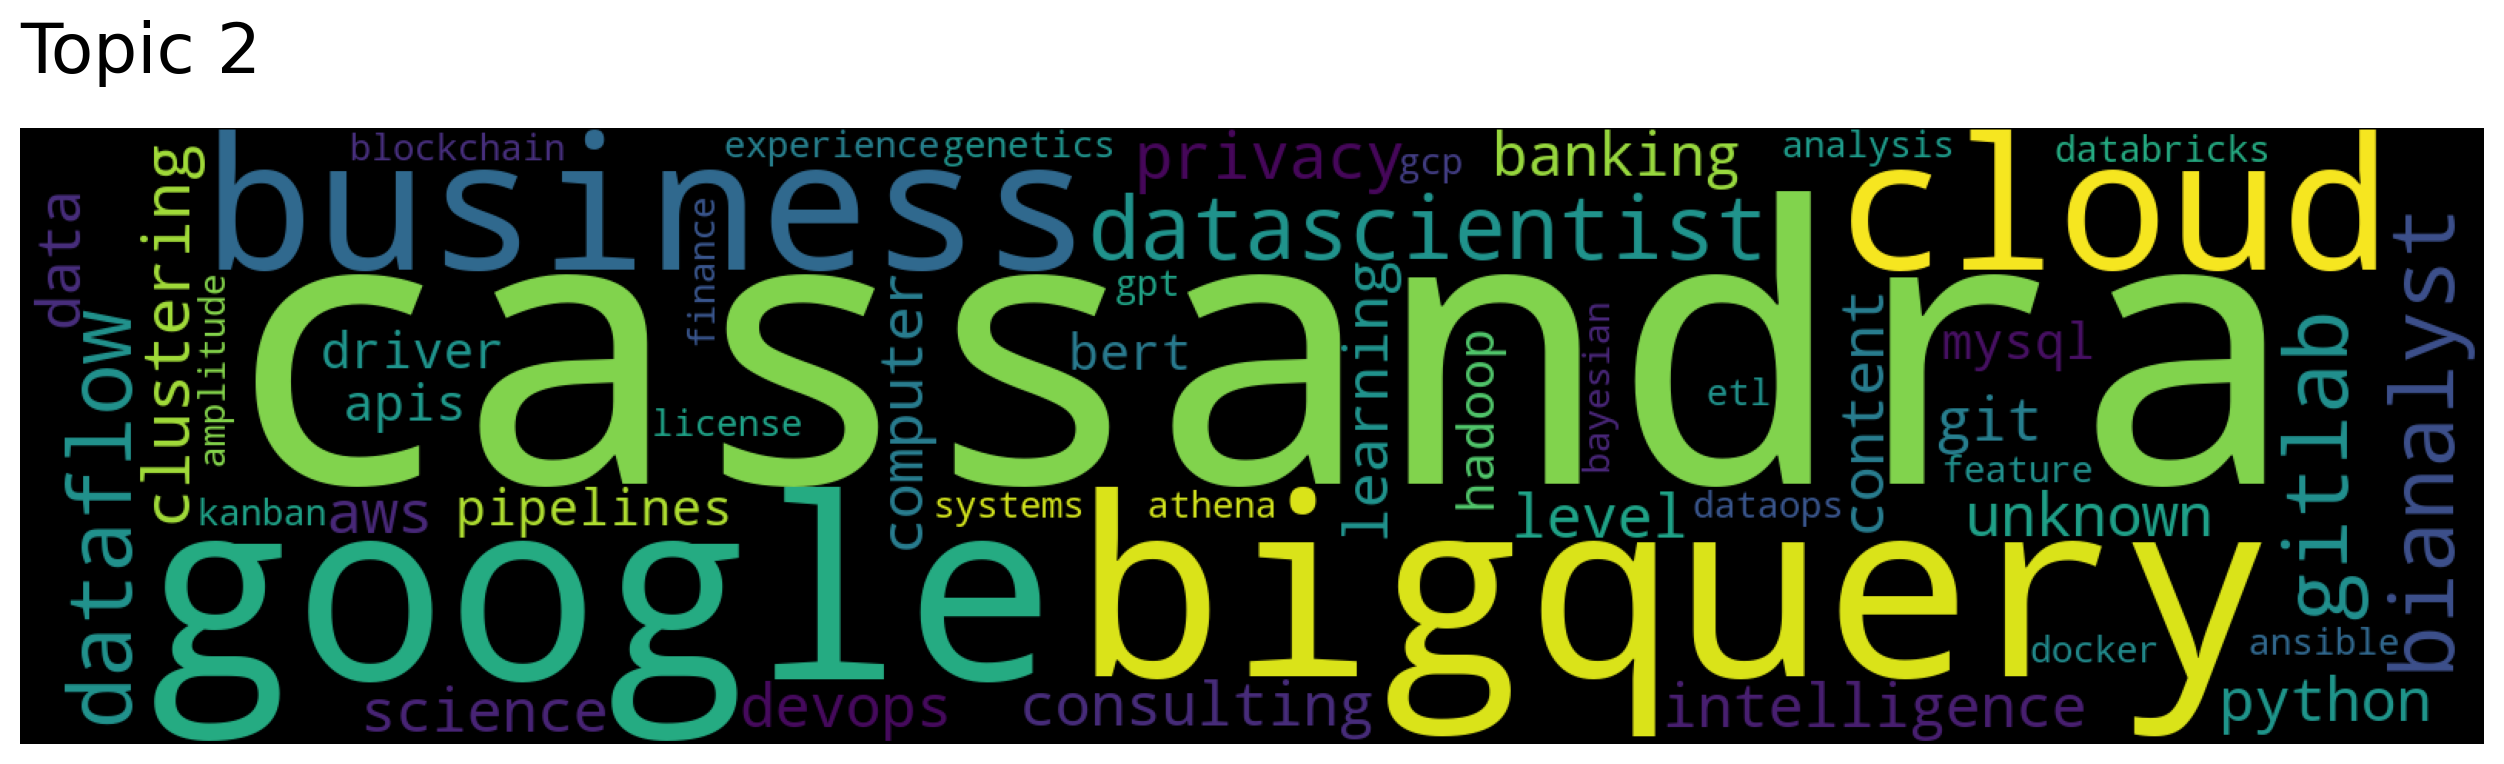

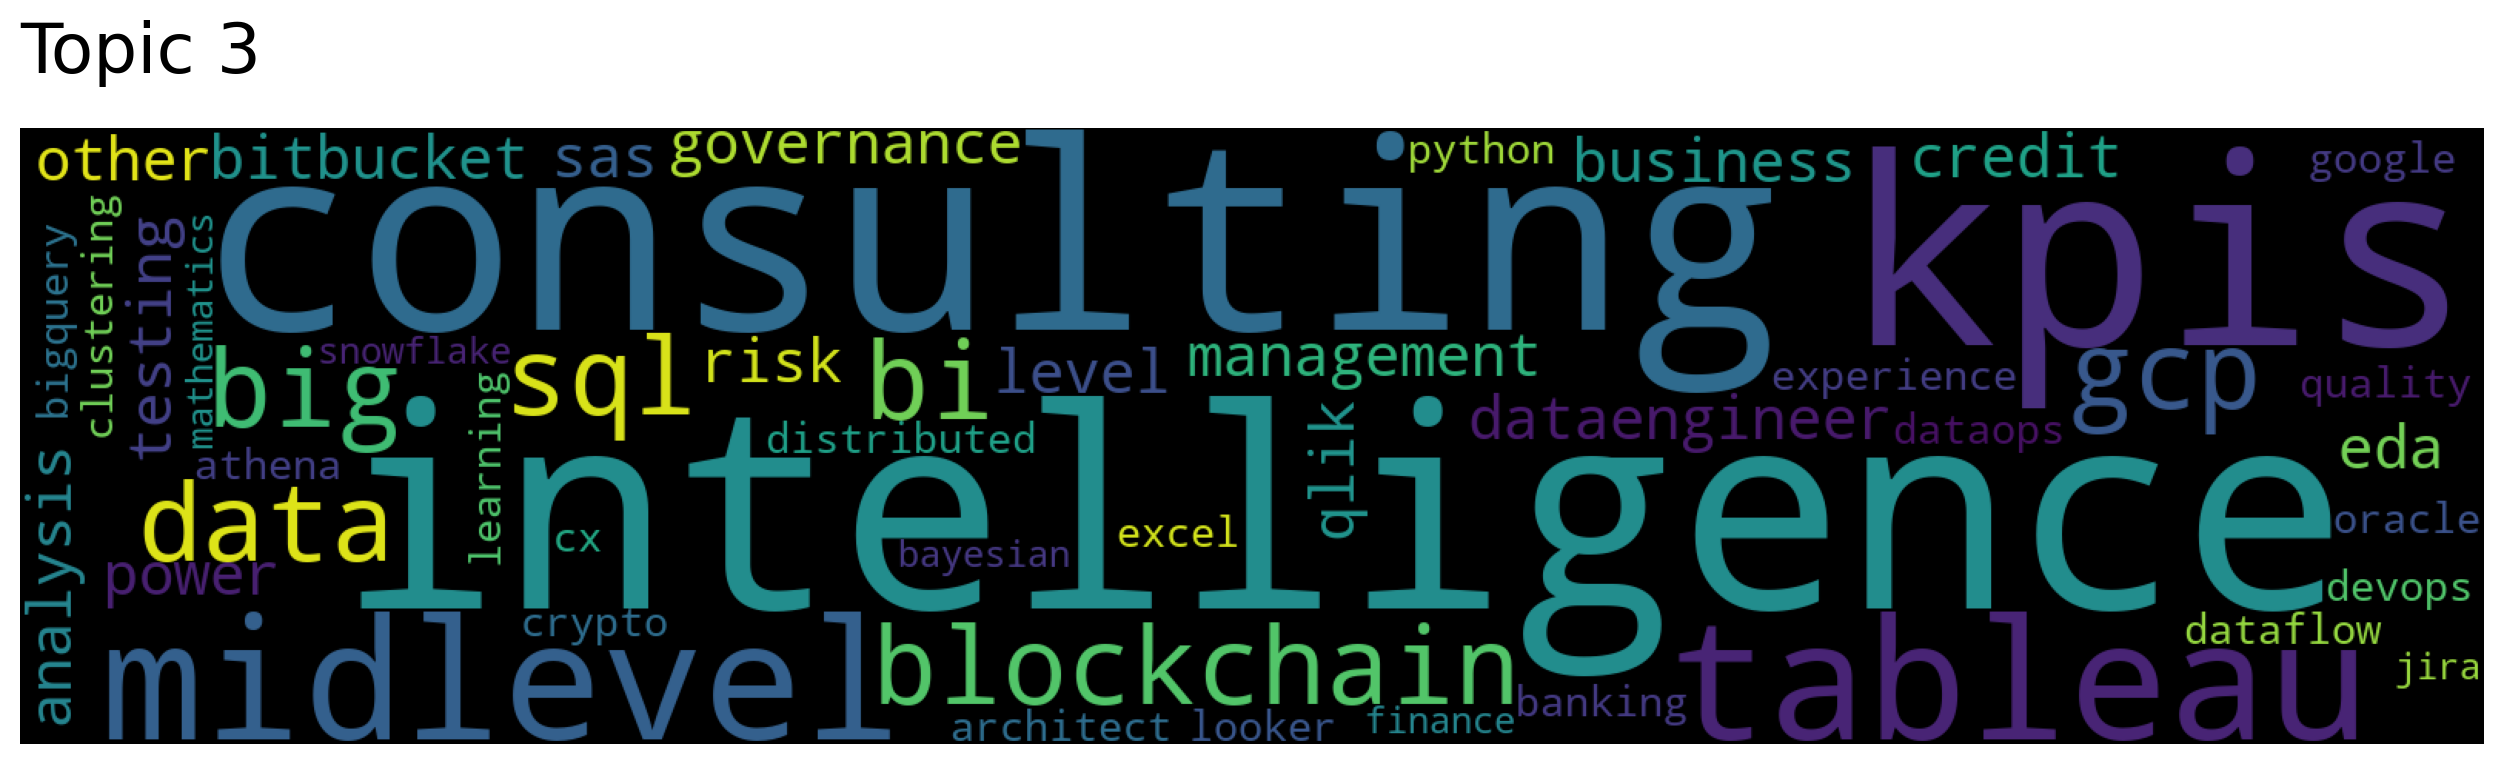

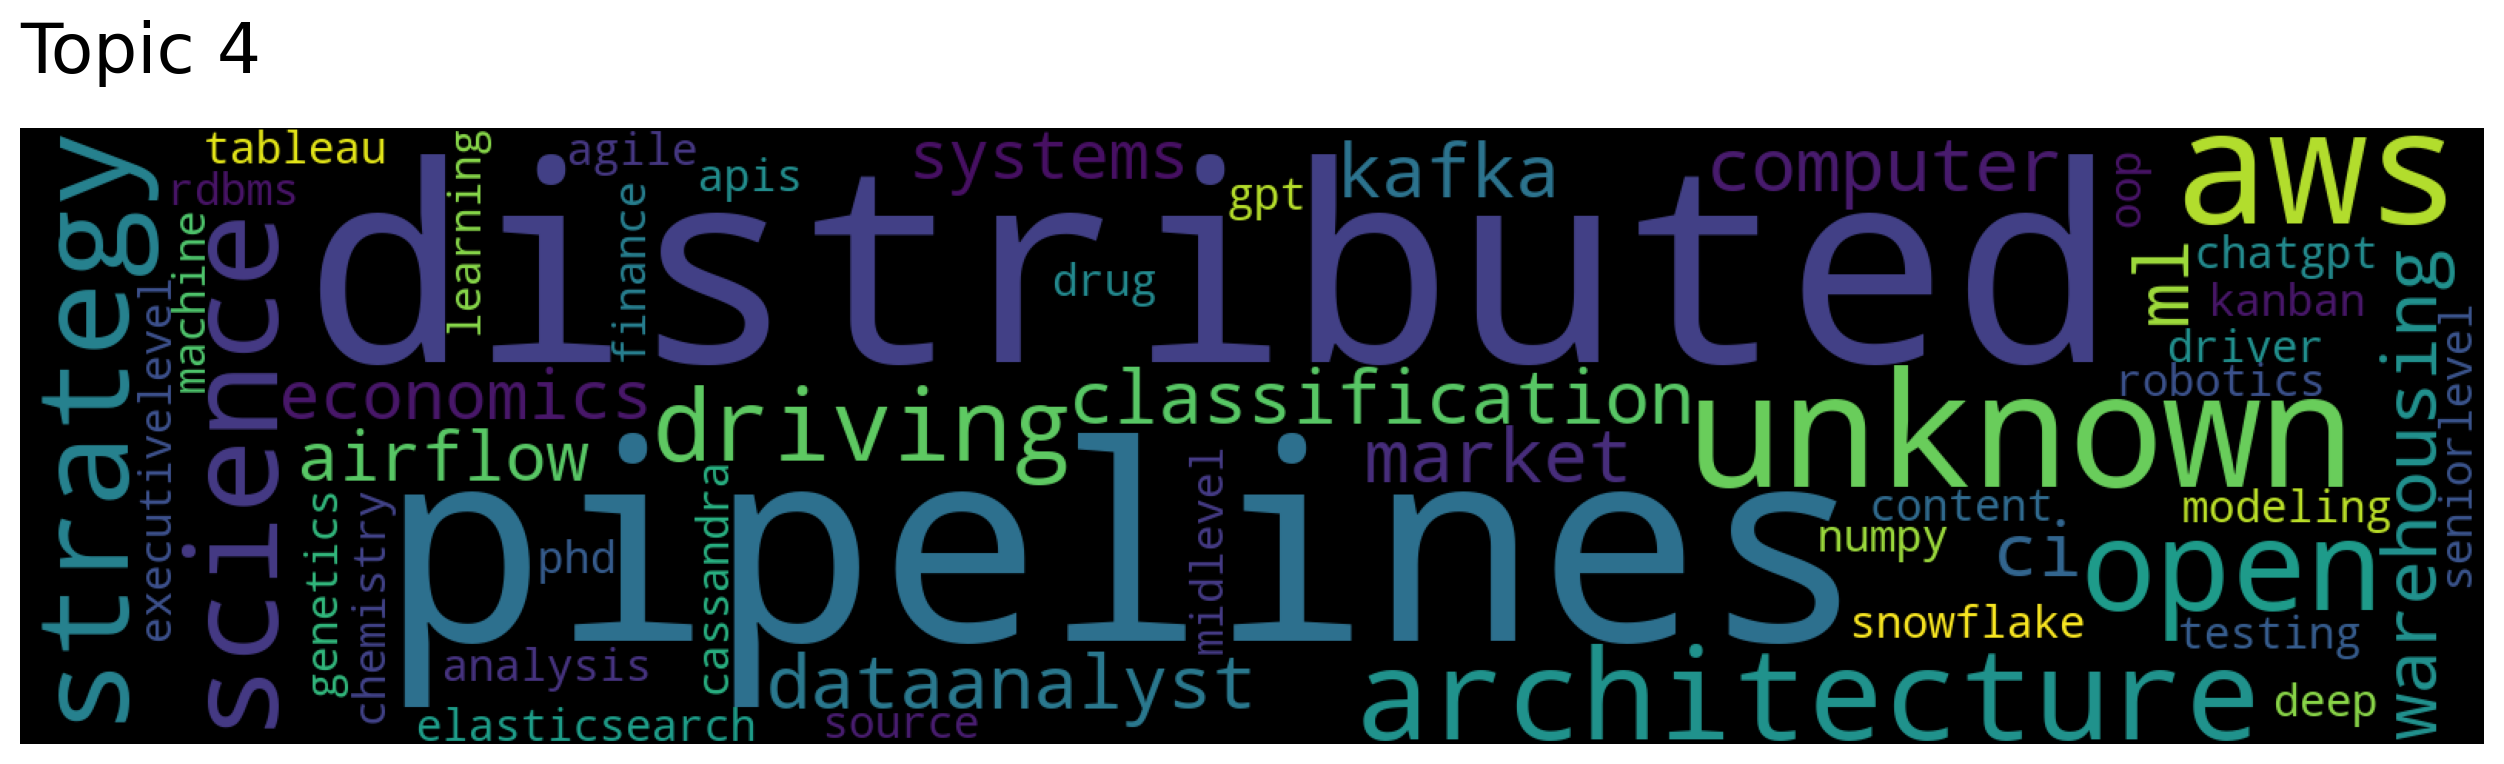

In [10]:

# Plot the resulting topics as wordclouds
load_model_time = time.time()
for topic in topic_nums:
    topic_model.generate_topic_wordcloud(topic)
end_load_model = time.time()
print("Total time to load model: ", end_load_model - load_model_time)